# Data Pipeline

<p align='center'><img width="1000" src="https://drive.google.com/uc?export=view&id=1OQeyFq3jpzrBZE4OtUcCarO0U2tUiVzR"></p>


## Setup

In [1]:
!pip install wikipedia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11695 sha256=f305c861a79dcc8f2dd1f8a814b7ae4d006318eaf9c5e2db9ca18c73e9f2f248
  Stored in directory: /root/.cache/pip/wheels/07/93/05/72c05349177dca2e0ba31a33ba4f7907606f7ddef303517c6a
Successfully built wikipedia


In [2]:
# import the necessary packages
import logging
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
sns.set()

In [3]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Creating the graph

This function gets a `SEED` and the `STOPS` to extract the pages and create a graph.

In [4]:
def create_graph(args: dict) -> nx.DiGraph:
  logger.info("[INFO] Creating graph")

  # organizating the search
  todo_lst = [(0, args['SEED'])] # The SEED is in the layer 0
  todo_set = set(args['SEED']) # The SEED itself
  done_set = set() # Nothing is done yet

  # creating the initial graph
  g = nx.DiGraph()
  layer, page = todo_lst[0]

  if os.path.isfile('extract.txt'):
    file = open('extract.txt', 'w')
  else:
    file = open('extract.txt', 'x')
    
  while layer < 2:
    # Remove the name page of the current page from the todo_lst, 
    # and add it to the set of processed pages. 
    # If the script encounters this page again, it will skip over it.
    del todo_lst[0]
    done_set.add(page)
    
    # Show progress
    # print(layer, page)
    file.write(f"{layer} {page}\n")
    
    # Attempt to download the selected page.
    try:
      wiki = wikipedia.page(page)
    except:
      # print("Could not load", page)
      file.write("Could not load\n")
      layer, page = todo_lst[0]
      continue
    
    for link in wiki.links:
      link = link.title()
      if link not in args['STOPS'] and not link.startswith("List Of"):
        if link not in todo_set and link not in done_set:
          todo_lst.append((layer + 1, link))
          todo_set.add(link)
        g.add_edge(page, link)
    layer, page = todo_lst[0]

  # close the file
  file.close()
  
  return g

## Preprocessing

Some nodes come as duplicates but in plural or with `-` between the words. For example, `Mark Shield` and `Mark Shields` or even `High-Fructose Corn Syrup` and `High Fructose Corn Syrup`. So, this function search these nodes and contract them into only one.

In [5]:
def preprocessing(g: nx.DiGraph) -> nx.DiGraph:
  logger.info("[INFO] Starting preprocessing")

  g.remove_edges_from(nx.selfloop_edges(g))

  # identify duplicates like that: 'network' and 'networks'
  duplicates = [(node, node + "s") 
                for node in g if node + "s" in g
              ]

  for dup in duplicates:
    # *dup is a technique named 'unpacking'
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  if os.path.isfile('preprocessing.txt'):
    file2 = open('preprocessing.txt', 'w')
  else:
    file2 = open('preprocessing.txt', 'x')

  # print(duplicates) # we can remove this line in the future
  file2.write(f"{duplicates}")

  duplicates = [(x, y) for x, y in 
                [(node, node.replace("-", " ")) for node in g]
                  if x != y and y in g]

  # print(duplicates) # we can remove this line in the future
  file2.write(f"{duplicates}")
  file2.close()

  for dup in duplicates:
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  # nx.contracted creates a new node/edge attribute called contraction
  # the value of the attribute is a dictionary, but GraphML
  # does not support dictionary attributes
  nx.set_node_attributes(g, 0,"contraction")
  nx.set_edge_attributes(g, 0,"contraction")

  file2.close()
  return g

## Truncate the network

Most of the nodes in this network have only one connection. So, this function removes these nodes with only one incident edge to make the network more compact and less hairy without hurting the final results

In [6]:
def plot_histogram(g: nx.DiGraph):
  plt.style.use("default")
  # degree sequence
  degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  

  fig, ax = plt.subplots(1,2,figsize=(8,4))

  # all_data has information about degree_sequence and the width of each bin
  ax[0].hist(degree_sequence)
  ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

  ax[0].set_title("Degree Histogram")
  ax[0].set_ylabel("Count")
  ax[0].set_xlabel("Degree")
  ax[0].set_ylim(0,15000)

  ax[1].set_title("Degree Histogram - Zoom")
  ax[1].set_ylabel("Count")
  ax[1].set_xlabel("Degree")
  ax[1].set_xlim(0,10)
  ax[1].set_ylim(0,15000)

  plt.tight_layout()
  plt.show()

In [7]:
def truncate(g: nx.DiGraph) -> nx.DiGraph:
  logger.info("[INFO] Starting to truncate the network")

  # checking the degree for each node
  plot_histogram(g)

  # filter nodes with degree greater than or equal to 2
  core = [node for node, deg in dict(g.degree()).items() if deg >= 2]

  # select a subgraph with 'core' nodes
  gsub = nx.subgraph(g, core)

  logger.info("{} nodes, {} edges".format(len(gsub), nx.number_of_edges(gsub)))

  # reporting the final graph
  nx.write_graphml(gsub, "cna.graphml")

  logger.info("Nodes removed: {:.2f}%".format(100*(1 - len(gsub)/len(g))))
  logger.info("Edges removed: {:.2f}%".format(100*(1 - nx.number_of_edges(gsub)/nx.number_of_edges(g))))
  logger.info("Edges per nodes: {:.2f}".format(nx.number_of_edges(gsub)/len(gsub)))

## Composing the functions

We must put all pipeline steps into functions to use `compose()`. This function gets the output from first funcion and pass as argument to next. 

In [8]:
def compose (*functions):
    def inner(arg):
        for f in functions:
            arg = f(arg)
        return arg
    return inner

In [9]:
# setup seed and stops
SEED = "2022 FIFA World Cup".title()
STOPS = ("FIFA",
         "FIFA 2022",
         "FIFA World Cup",
         "2022 tournament")

args = {
    'SEED': SEED,
    'STOPS': STOPS
}

06-12-2022 19:21:49 [INFO] Creating graph
/usr/local/lib/python3.8/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.8/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
06-12-2022 19:27:37 [INFO] Starting preprocessing
06-12-2022 19:31:09 [INFO] Starting to truncate the network


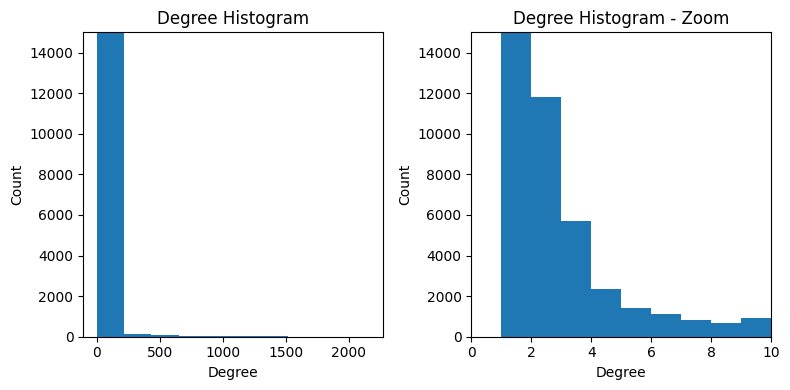

06-12-2022 19:31:10 27563 nodes, 164356 edges
06-12-2022 19:31:14 Nodes removed: 65.57%
06-12-2022 19:31:15 Edges removed: 24.20%
06-12-2022 19:31:15 Edges per nodes: 5.96


In [10]:
composed = compose(create_graph, preprocessing, truncate)
composed(args)